# Tutorial

`micromodelsim` enables the simulation of diffusion-weighted nuclear magnetic resonance (NMR) measurements using microstructural models. The purpose of the package is to provide an easy-to-use interface to accelerated numerical simulations. This tutorial covers the package's basic functionality, and we recommend the reader to also look at the reference and examples.

Let's start by importing the required packages.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import micromodelsim as mmsim

## Gradients

Every simulation requires defining the simulated b-values and b-vectors. Gradient information is stored in a `Gradient` object. The code below defines and visualizes a two-shell acquisition protocol.

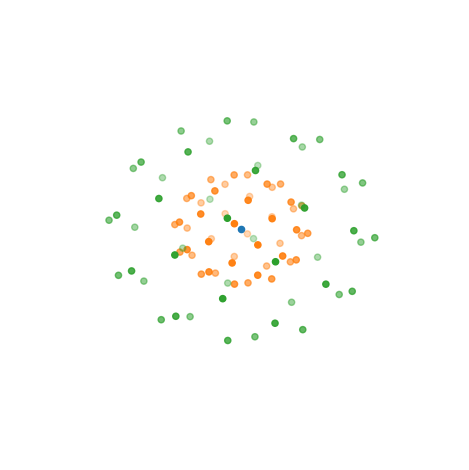

In [2]:
vertices_fname = os.path.join(
    os.path.dirname(mmsim.__file__), "healpix", "vertices_48.txt"
)  # file containing 48 points uniformly distributed over the surface of a sphere
vertices = np.loadtxt(vertices_fname)  # an array with shape (number of directions, 3)

bvals = np.concatenate(
    (np.zeros(1), np.ones(len(vertices)), 2 * np.ones(len(vertices)))
)  # b0 and two non-zero b-values
bvecs = np.vstack((np.zeros((1, 3)), vertices, vertices))

gradient = mmsim.Gradient(bvals, bvecs)  # store gradient info in an object

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for idx in gradient.shell_idx_list:
    ax.scatter(
        bvals[idx] * bvecs[idx, 0],
        bvals[idx] * bvecs[idx, 1],
        bvals[idx] * bvecs[idx, 2],
    )
ax.set_axis_off()
fig.tight_layout()
plt.show()

## Diffusion tensor distribution simulation

The function `dtd_simulation` enables simulating measurements from a diffusion tensor distribution (DTD). The signal is given by the following equation:

$$S = \sum_{i=1}^N f_i \exp \left( -\mathbf{b}:\mathbf{D}_i \right)$$

where $N$ is the number of diffusion tensors, $f_i$ is a signal fraction, $\mathbf{b}$ is the b-tensor, $\mathbf{D}_i$ is a diffusion tensor, and $:$ denotes the generalized scalar product.

The code below generates signals from a simple DTD using the acquisition protocol defined above.

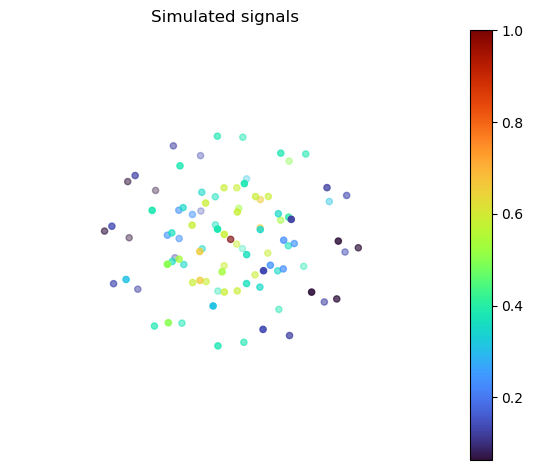

In [3]:
dtd = np.array(
    [
        [[2, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[2, 0, 0], [0, 0.5, 0], [0, 0, 0.5]],
        [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    ]
)  # an array with shape (number of diffusion tensors, 3, 3)

signals = mmsim.dtd_simulation(gradient, dtd)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(
    bvals * bvecs[:, 0],
    bvals * bvecs[:, 1],
    bvals * bvecs[:, 2],
    c=signals,
    cmap="turbo",
)
plt.colorbar(im)
ax.set_title("Simulated signals")
ax.set_axis_off()
fig.tight_layout()
plt.show()

## Compartment model simulation

The function `compartment_model_simulation` enables simulating measurements from a Gaussian compartment model and an orientation distribution function (ODF).

The signal is expressed as a spherical convolution of the ODF by a microstructural kernel response function $K$:

$$S(\mathbf{x}) = \int_{\mathbf{R} \in \text{SO}(3)} \text{d}\mathbf{R} \ \text{ODF}(\mathbf{R} \mathbf{\hat{e}_3}) K(\mathbf{R}^{-1} \mathbf{x})$$

where $\mathbf{x} \in S^2$ is the diffusion encoding direction and

$$K(\mathbf{\hat{n}}) = \sum_{i=1}^N f_i \exp(- \mathbf{b}:\mathbf{D}_i)$$

where $N$ is the number of compartments, $f_i$ is a signal fraction, $\mathbf{b}$ is the b-tensor corresponding to $\mathbf{\hat{n}}$ and a b-value equal to $\text{Tr}(\mathbf{b})$, $:$ denotes the generalized scalar product, and $\mathbf{D}_i$ is a diffusion tensor aligned with the $z$-axis.

### Spherical harmonics

ODFs are represented by spherical harmonics expansions. Spherical harmonics can be understood as a Fourier basis on the sphere. Because reconstructed diffusion MRI signals are real-valued and antipodally symmetric, the following basis is used:

$$S_l^m = \left\{\begin{matrix} 0 & \text{if } l \text{ is odd} \\ \sqrt{2} \ \Im \left( Y_l^{-m} \right) & \text{if} \ m < 0 \\  Y_l^0 & \text{if} \ m = 0 \\ \sqrt{2} \ \Re \left( Y_l^{m} \right) & \text{if} \ m > 0  \end{matrix}\right. $$

where $l$ is the degree, $m$ is the order, and $Y_l^m$ is a spherical harmonic:

$$Y_l^m(\theta, \phi) = \sqrt{\frac{2l + 1}{4 \pi} \frac{(l - m)!} {(l + m)!}} P_l^m(\cos \theta) e^{im\phi}$$

where $\theta \in [0, \pi]$ is the polar angle and $\phi \in [0, 2\pi)$ is the azimuthal angle.

ODFs must be represented as a 1D arrays using the following indexing:

$$i = \frac{1}{2}l(l + 1) + m$$

The number of coefficients $N$ depends on the largest degree in the expansion $l_\text{max}$:

$$N = \frac{1}{2}(l_\text{max} + 1)(l_\text{max} + 2)$$

The ODFs don't have to be normalized as the `compartment_model_simulation` function does the normalization.

The code snippets below visualize the basis functions until $l = 8$ and then define and visualize a spherical harmonics expansion with $l_\text{max} = 8$.

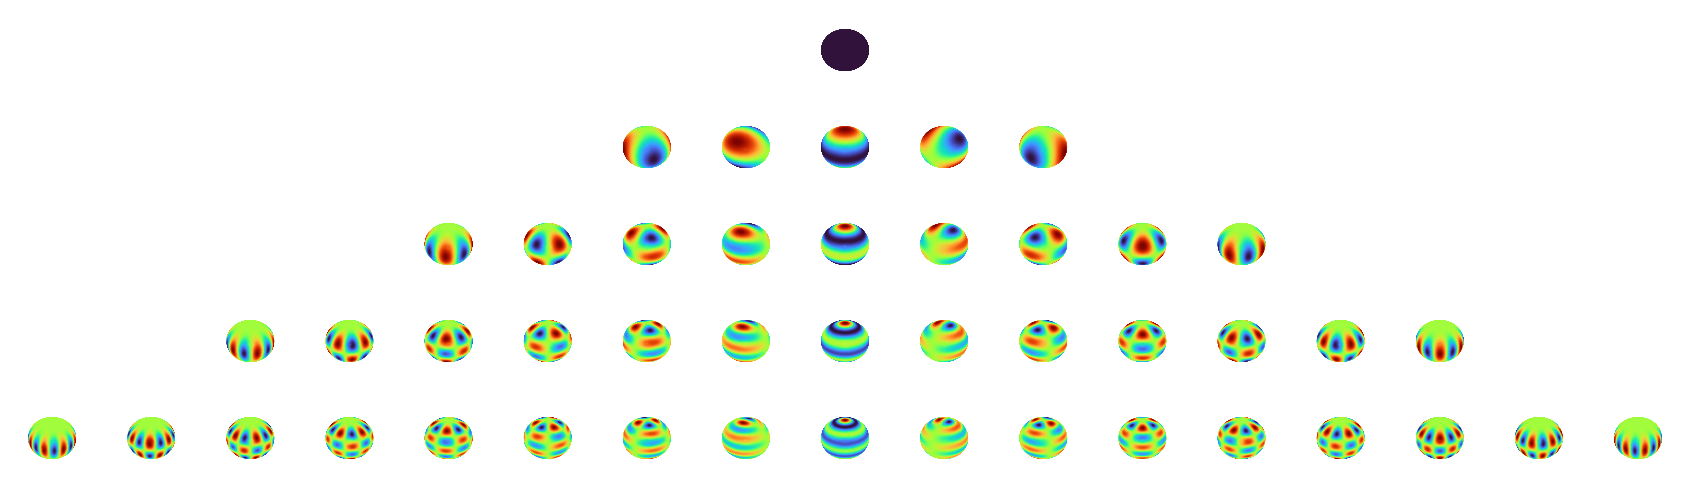

In [4]:
N = 100  # determines the resolution (higher resolution takes longer to render)

mg_thetas, mg_phis = np.meshgrid(
    np.linspace(0, np.pi, N), np.linspace(0, 2 * np.pi, 2 * N)
)

fig = plt.figure(figsize=(17, 5))
l_max = 8
for l in range(0, l_max + 1, 2):
    c = int(l / 2 * 17) + l_max - l
    for m in range(-l, l + 1):
        c += 1
        ax = fig.add_subplot(5, 17, c, projection="3d")
        values = mmsim.sh(l, m, mg_thetas, mg_phis)
        if l == 0:
            fcolors = np.zeros(values.shape)
        else:
            fcolors = (values - np.min(values)) / (np.max(values) - np.min(values))
        ax.plot_surface(
            np.sin(mg_thetas) * np.cos(mg_phis),
            np.sin(mg_thetas) * np.sin(mg_phis),
            np.cos(mg_thetas),
            facecolors=matplotlib.cm.turbo(fcolors),
            rcount=2 * N,
            ccount=N,
            shade=False,
        )
        ax.set_axis_off()
fig.tight_layout()
plt.show()

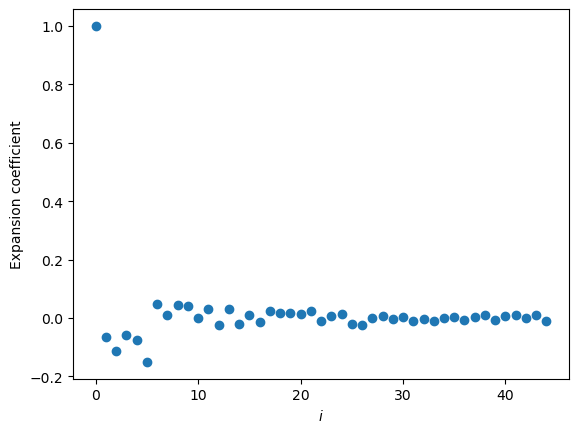

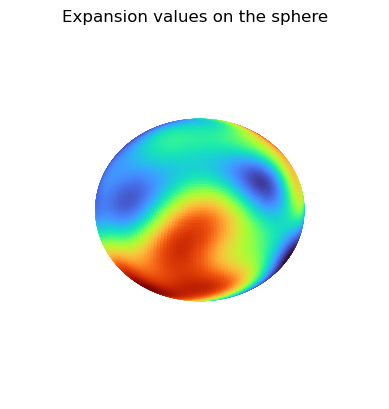

In [5]:
l_max = 8
n_coeffs = int(0.5 * (l_max + 1) * (l_max + 2))

l0s = np.zeros(n_coeffs)
for l in range(0, l_max + 1, 2):
    for m in range(-l, l + 1):
        l0s[int(0.5 * l * (l + 1) + m)] = int(0.5 * l * (l + 1))
coeffs = np.ones(n_coeffs)
np.random.seed(666)
coeffs[1::] = 1 / l0s[1::] * (0.5 - np.random.random(n_coeffs - 1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(n_coeffs), coeffs)
ax.set_xlabel("$i$")
ax.set_ylabel("Expansion coefficient")
plt.show()

values = np.zeros(mg_thetas.shape)
for l in range(0, l_max + 1, 2):
    for m in range(-l, l + 1):
        i = int(0.5 * l * (l + 1) + m)
        values += coeffs[i] * mmsim.sh(l, m, mg_thetas, mg_phis)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
fcolors = (values - np.min(values)) / (np.max(values) - np.min(values))
im = ax.plot_surface(
    np.sin(mg_thetas) * np.cos(mg_phis),
    np.sin(mg_thetas) * np.sin(mg_phis),
    np.cos(mg_thetas),
    facecolors=matplotlib.cm.turbo(fcolors),
    rcount=2 * N,
    ccount=N,
    shade=False,
)
ax.set_title("Expansion values on the sphere")
ax.set_axis_off()
plt.show()

### Signal generation

Now that we have an ODF, we can define the compartment signal fractions, axial diffusivities, and radial diffusivites, and generate synthetic signals:

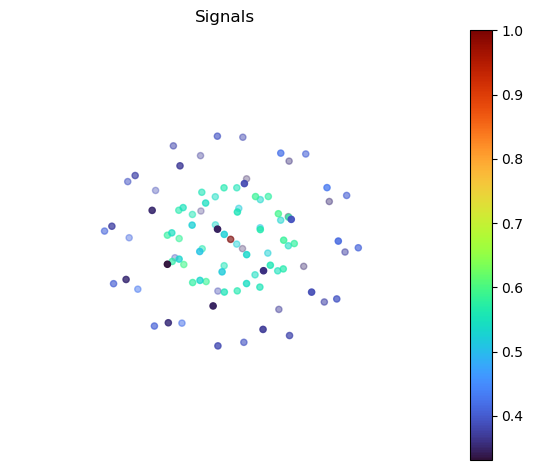

In [6]:
fs = np.array([0.8, 0.2])[
    np.newaxis
]  # an array with shape (n of simulations, n of compartments)
ads = np.array([2, 1])[
    np.newaxis
]  # an array with shape (n of simulations, n of compartments)
rds = np.array([0, 1])[
    np.newaxis
]  # an array with shape (n of simulations, n of compartments)
odfs_sh = coeffs[
    np.newaxis
]  # an array with shape (n of simulations, n of coefficients)
signals = mmsim.compartment_model_simulation(gradient, fs, ads, rds, odfs_sh)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(
    bvals * bvecs[:, 0],
    bvals * bvecs[:, 1],
    bvals * bvecs[:, 2],
    c=signals,
    cmap="turbo",
)
plt.colorbar(im)
ax.set_title("Simulated signals")
ax.set_axis_off()
fig.tight_layout()
plt.show()

## Adding noise

The function `add_noise` allows Rician noise to be added to the simulated signals. Pseudo-random number generator seed can be set with `numpy.random.seed`.

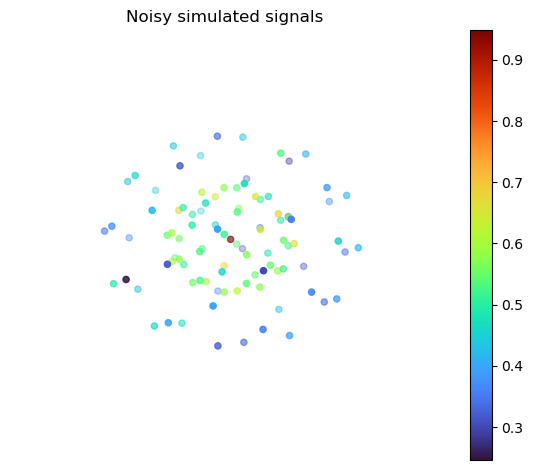

In [7]:
snr = 20  # signal-to-noise ratio

np.random.seed(123)  # set seed

noisy_signals = mmsim.add_noise(signals, snr)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(
    bvals * bvecs[:, 0],
    bvals * bvecs[:, 1],
    bvals * bvecs[:, 2],
    c=noisy_signals,
    cmap="turbo",
)
plt.colorbar(im)
ax.set_title("Noisy simulated signals")
ax.set_axis_off()
fig.tight_layout()
plt.show()